In [ ]:
import sys
import os
import csv

%pip install --upgrade pip
%pip install tensorflow
%pip install tensorflow-datasets
%pip install torch torchvision torchaudio
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip -q install tensorflow-datasets pillow torchvision matplotlib
%pip install eniops
%pip install compressai pillow torchvision tqdm scikit-image


In [22]:
import os, csv, numpy as np, torch
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from compressai.zoo import bmshj2018_hyperprior  # swap model if you like

In [ ]:
# Path where the Kodak dataset (24 PNG images) is stored
data_dir = "data_kodak"

# Select the device: use GPU ("cuda") if available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# List of pretrained model "quality" levels (1–8). 
# Lower = more compression (smaller files, lower quality); higher = less compression (larger files, higher quality)
qualities = [1, 2, 3, 4, 5, 6, 7, 8]

# Natural log of 2 — used to convert nats (from torch.log) into bits (log base 2)
ln2 = np.log(2.0)

# Empty list that will store one dictionary per quality level 
# Each entry holds the average bpp, PSNR, and MS-SSIM for that model
rd_points = []

# Loop through every quality level — each corresponds to a separate pretrained CompressAI model
for q in qualities:
    # Load the pretrained Ballé et al. 2018 (bmshj2018_hyperprior) model for this quality level
    # .to(device) moves it to GPU or CPU; .eval() sets it to inference mode
    model = bmshj2018_hyperprior(quality=q, pretrained=True).to(device).eval()

    # Create empty lists to collect per-image results at this quality
    bpps, psnrs, msssims = [], [], []

    # Disable gradient computation for faster inference and lower memory usage
    with torch.no_grad():
        # Iterate over every file name in the Kodak folder, sorted alphabetically
        for fname in sorted(os.listdir(data_dir)):
            # Skip any files that aren’t PNG images (case-insensitive)
            if not fname.lower().endswith(".png"):
                continue

            # Build the full path to the image file
            path = os.path.join(data_dir, fname)

            # Load the image and ensure it has 3 RGB channels
            img = Image.open(path).convert("RGB")

            # Convert the PIL image to a PyTorch tensor in [0,1] range and add a batch dimension [1,3,H,W]
            x = TF.to_tensor(img).unsqueeze(0).to(device)

            # Feed the image through the compression model
            out = model(x)

            # Retrieve the reconstructed (decompressed) image, clamped to valid [0,1] range
            x_hat = out["x_hat"].clamp(0, 1)

            # Retrieve the model’s estimated likelihoods of latent representations (for bitrate computation)
            lik = out["likelihoods"]

            # ---- Rate calculation (bits per pixel) ----
            # Get image height (H) and width (W)
            H, W = x.shape[-2:]
            bpp = 0.0
            # Each likelihood tensor corresponds to a part of the entropy model
            # We compute expected code length: −log2(p) averaged per pixel
            for p in lik.values():
                bpp += (-torch.log(p).sum() / (H * W) / ln2).item()

            # ---- Distortion calculation ----
            # Convert tensors back to NumPy arrays in H×W×3 format and float32 type
            x_np    = x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)
            xhat_np = x_hat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)

            # Compute PSNR (Peak Signal-to-Noise Ratio) between original and reconstruction
            psnr_val = psnr(x_np, xhat_np, data_range=1.0)

            # Compute SSIM (Structural Similarity Index) — perceptual similarity metric
            ssim_val = ssim(x_np, xhat_np, channel_axis=2, data_range=1.0)

            # Store per-image results for this quality level
            bpps.append(bpp)
            psnrs.append(psnr_val)
            msssims.append(ssim_val)

    # ---- After finishing all 24 Kodak images for this quality ----
    # Compute dataset averages for bitrate, PSNR, and SSIM
    avg_bpp  = float(np.mean(bpps))
    avg_psnr = float(np.mean(psnrs))
    avg_mss  = float(np.mean(msssims))

    # Save these averages to the rd_points list (for plotting later)
    rd_points.append({
        "quality": q,
        "bpp": avg_bpp,
        "psnr": avg_psnr,
        "ms_ssim": avg_mss
    })

    # Print progress — one summary line per quality level
    print(f"q={q}: bpp={avg_bpp:.4f}  PSNR={avg_psnr:.2f}  MS-SSIM={avg_mss:.4f}")


q=1: bpp=0.1311  PSNR=27.58  MS-SSIM=0.7455
q=2: bpp=0.2087  PSNR=29.20  MS-SSIM=0.7991
q=3: bpp=0.3195  PSNR=30.97  MS-SSIM=0.8511
q=4: bpp=0.4776  PSNR=32.84  MS-SSIM=0.8935
q=5: bpp=0.6672  PSNR=34.53  MS-SSIM=0.9235
q=6: bpp=0.9373  PSNR=36.74  MS-SSIM=0.9470
q=7: bpp=1.2566  PSNR=38.58  MS-SSIM=0.9627
q=8: bpp=1.6564  PSNR=40.56  MS-SSIM=0.9743


Saved: rd_compressai_kodak.csv


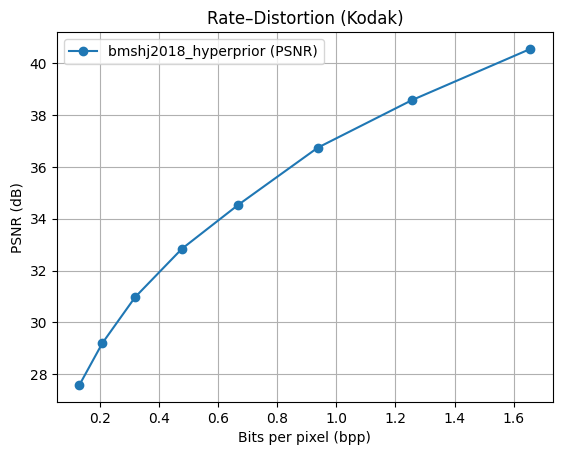

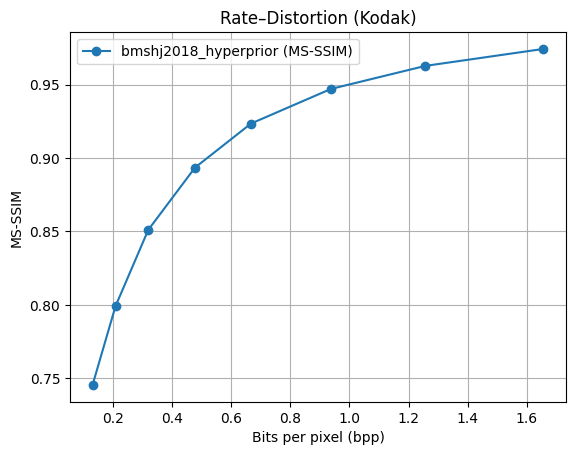

In [24]:
# ---- save CSV ----
csv_path = "rd_compressai_kodak.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["quality","bpp","psnr","ms_ssim"])
    w.writeheader()
    for r in rd_points:
        w.writerow(r)
print("Saved:", csv_path)

# ---- plot RD curves ----
bpp = [r["bpp"] for r in rd_points]
psn = [r["psnr"] for r in rd_points]
mss = [r["ms_ssim"] for r in rd_points]

plt.figure()
plt.plot(bpp, psn, marker="o", label="bmshj2018_hyperprior (PSNR)")
plt.xlabel("Bits per pixel (bpp)")
plt.ylabel("PSNR (dB)")
plt.title("Rate–Distortion (Kodak)")
plt.grid(True); plt.legend()
plt.show()

plt.figure()
plt.plot(bpp, mss, marker="o", label="bmshj2018_hyperprior (MS-SSIM)")
plt.xlabel("Bits per pixel (bpp)")
plt.ylabel("MS-SSIM")
plt.title("Rate–Distortion (Kodak)")
plt.grid(True); plt.legend()
plt.show()